# Lectura y Análisis

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [54]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [55]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

location = "la_orotava"

grafcan = "grafcan_la_orotava"
openmeteo_arpege = "openmeteo_la_orotava_arpege"
openmeteo_icon = "openmeteo_la_orotava_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_la_orotava...
air_temperature          12.039377
atmospheric_pressure    928.971242
relative_humidity        76.251114
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           8.489932
atmospheric_pressure    925.034831
relative_humidity        67.443335
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_la_orotava_arpege...
air_temperature          11.8
atmospheric_pressure    931.5
relative_humidity        91.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          11.3
atmospheric_pressure    927.1
relative_humidity        85.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_la_orotava_icon...
air_temperature          12.2
atmospheric_pressure    932.1
relative_humidity        91.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           9.8
atmospheric_pressure    927.6
relative_humidity        96.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [56]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


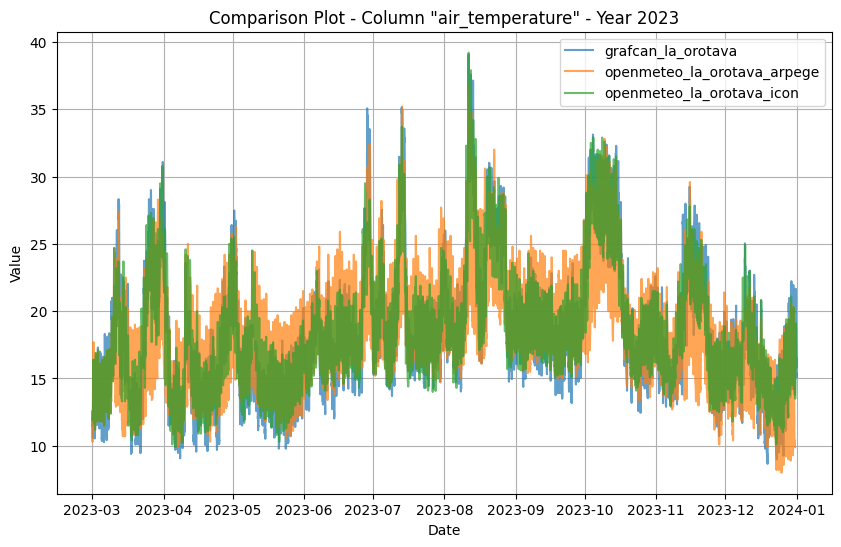

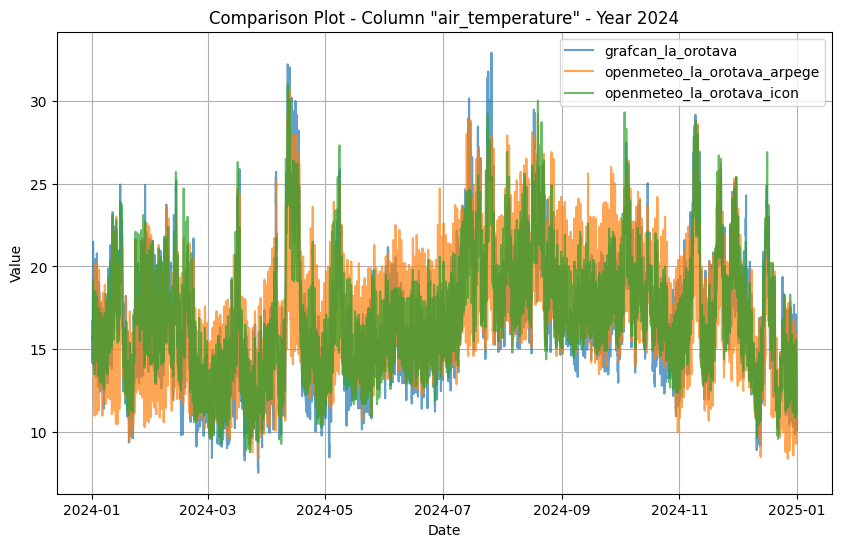

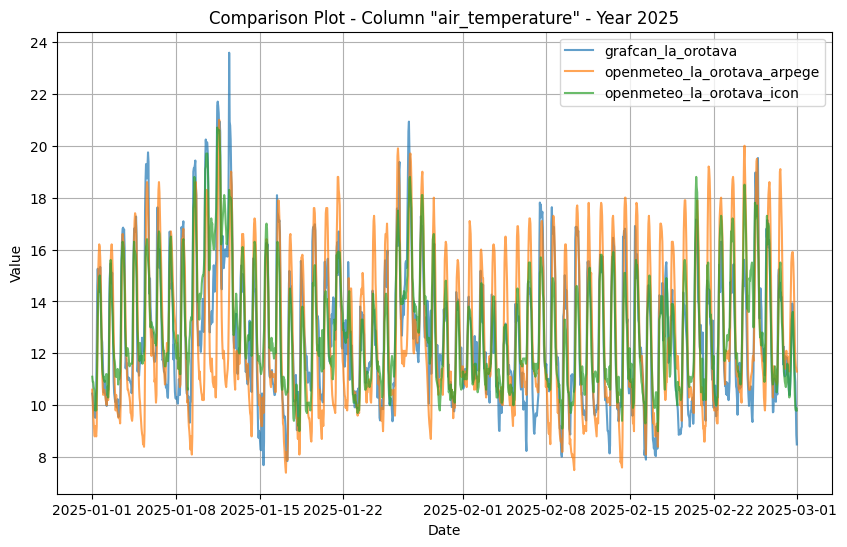

Plotting relative_humidity


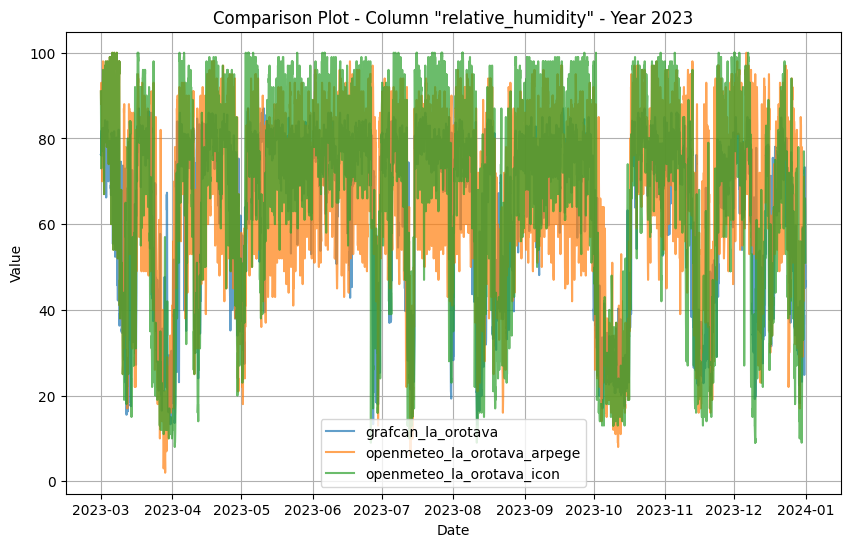

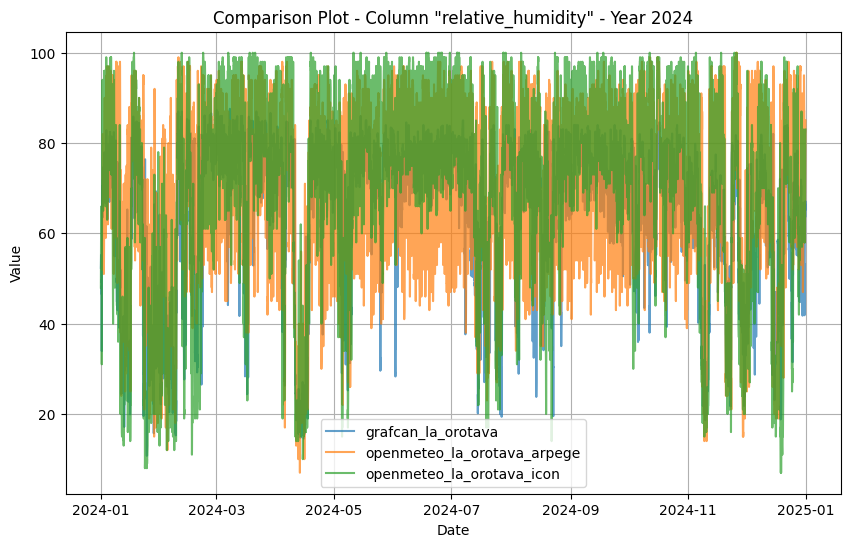

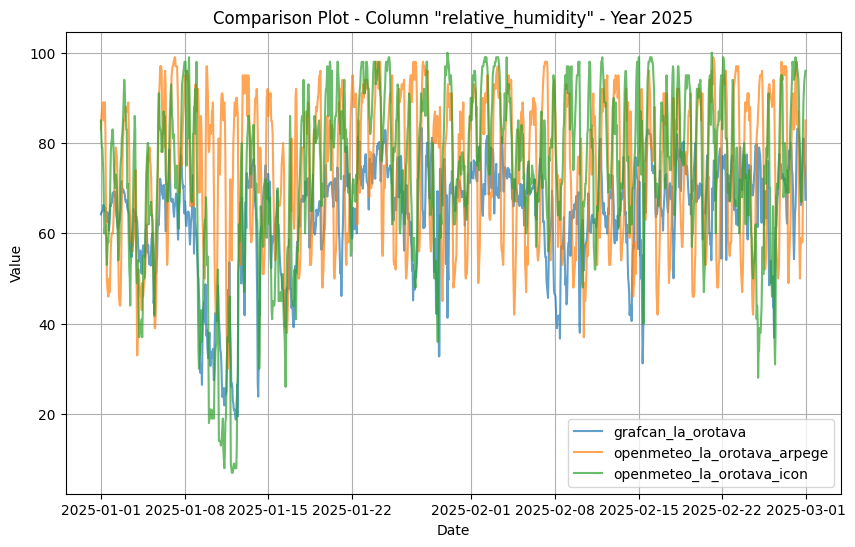

Plotting atmospheric_pressure


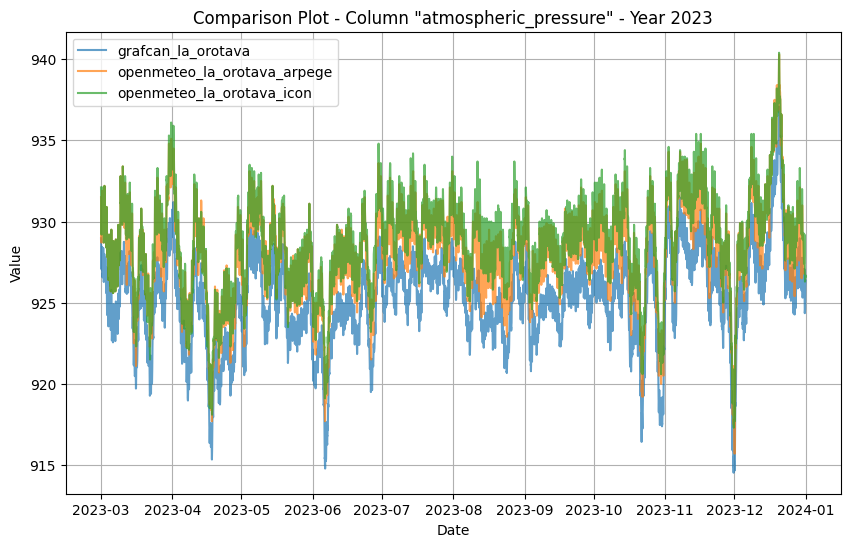

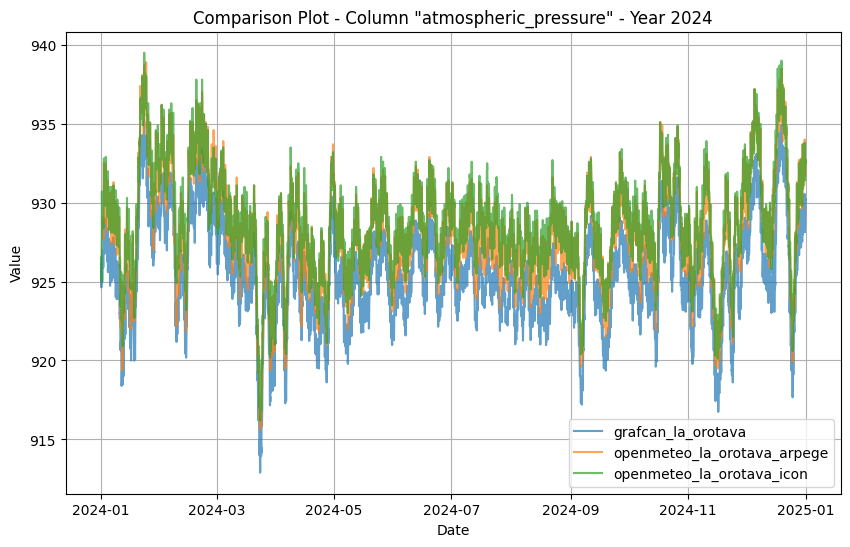

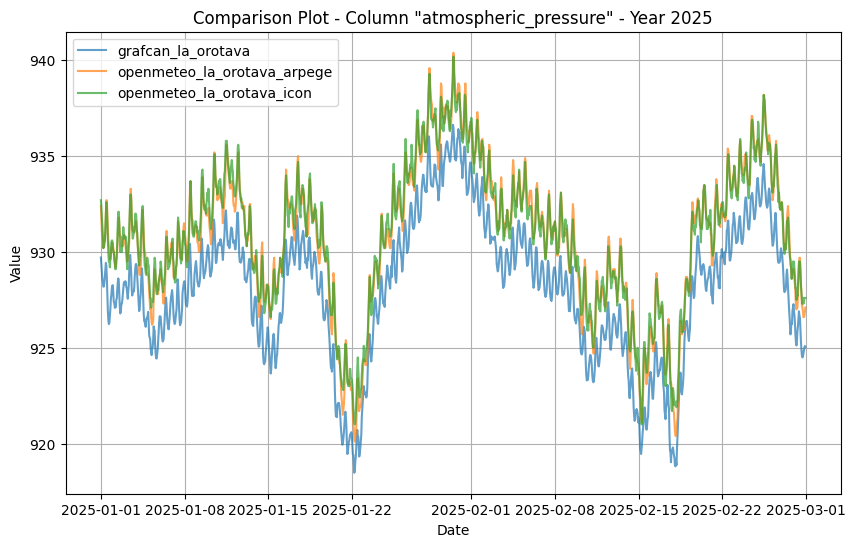

In [57]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [58]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_la_orotava after resampling:
[Timestamp('2024-02-09 12:00:00+0000', tz='UTC'), Timestamp('2024-11-15 11:00:00+0000', tz='UTC'), Timestamp('2024-11-15 12:00:00+0000', tz='UTC')]
3
Missing hours in openmeteo_la_orotava_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'

### Manejo Horas faltantes

In [59]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= threshold hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [60]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [61]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [62]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_la_orotava_icon vs grafcan_la_orotava
  air_temperature:
    Pearson: 0.9248
    Spearman: 0.9219
    Kendall: 0.7620
    MSE: 3.0152
    Euclidean Distance: 229.9978
  atmospheric_pressure:
    Pearson: 0.9634
    Spearman: 0.9508
    Kendall: 0.8202
    MSE: 12.5105
    Euclidean Distance: 468.4908
  relative_humidity:
    Pearson: 0.7627
    Spearman: 0.6272
    Kendall: 0.4552
    MSE: 254.2999
    Euclidean Distance: 2112.2115


In [63]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_la_orotava_arpege vs grafcan_la_orotava
  air_temperature:
    Pearson: 0.8115
    Spearman: 0.8221
    Kendall: 0.6365
    MSE: 7.4863
    Euclidean Distance: 362.4076
  atmospheric_pressure:
    Pearson: 0.9654
    Spearman: 0.9529
    Kendall: 0.8223
    MSE: 9.1583
    Euclidean Distance: 400.8401
  relative_humidity:
    Pearson: 0.4149
    Spearman: 0.2992
    Kendall: 0.2048
    MSE: 438.2895
    Euclidean Distance: 2772.9680


### Selección de datasets

In [64]:
ned_df_openmeteo = "openmeteo_" + location
dataframes[ned_df_openmeteo] = dataframes[openmeteo_icon].copy()
dataframes[ned_df_openmeteo]["atmospheric_pressure"] = dataframes[openmeteo_arpege]["atmospheric_pressure"].copy()
dataframes[ned_df_openmeteo]["artificial_value_flag"] += dataframes[openmeteo_arpege]["artificial_value_flag"]

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [65]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_la_orotava:


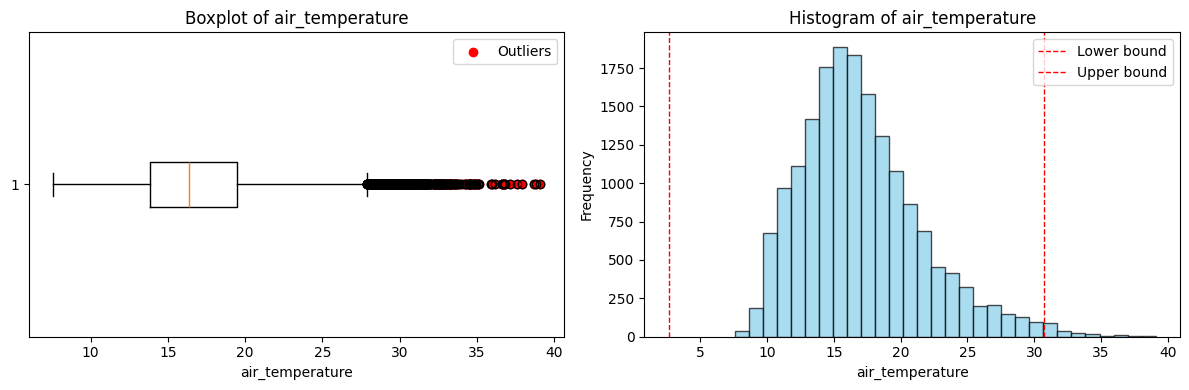

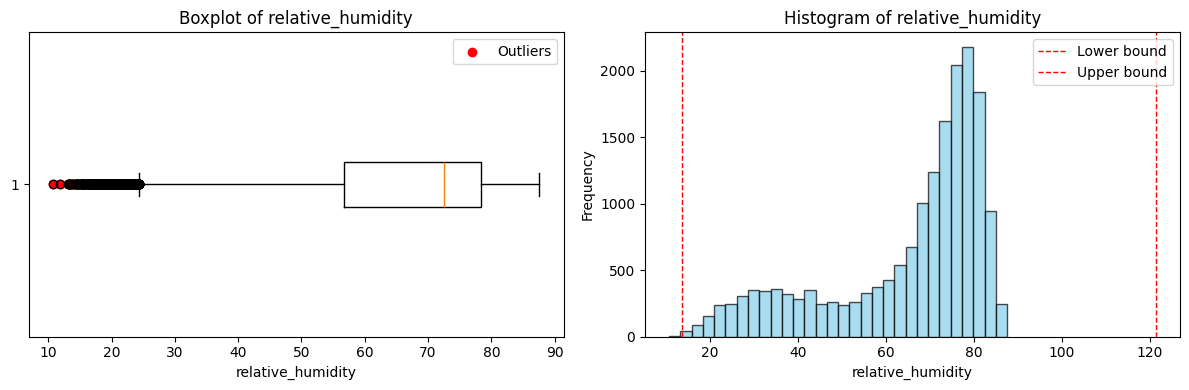

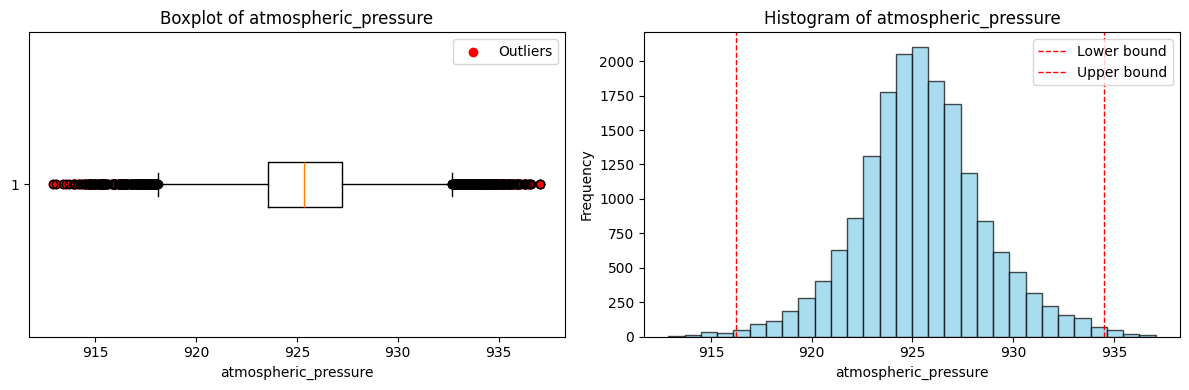

  air_temperature outlier row indices: [Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-03-31 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 08:00:00+0000', tz='UTC'), Timestamp('2023-06-28 09:00:00+0000', tz='UTC'), Timestamp('2023-06-28 10:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 18:00:00+0000', tz='UTC'), Timestamp('2023-06-28 19:00:00+0000', tz='UTC'), Timestamp('2023-06-29 09:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:0

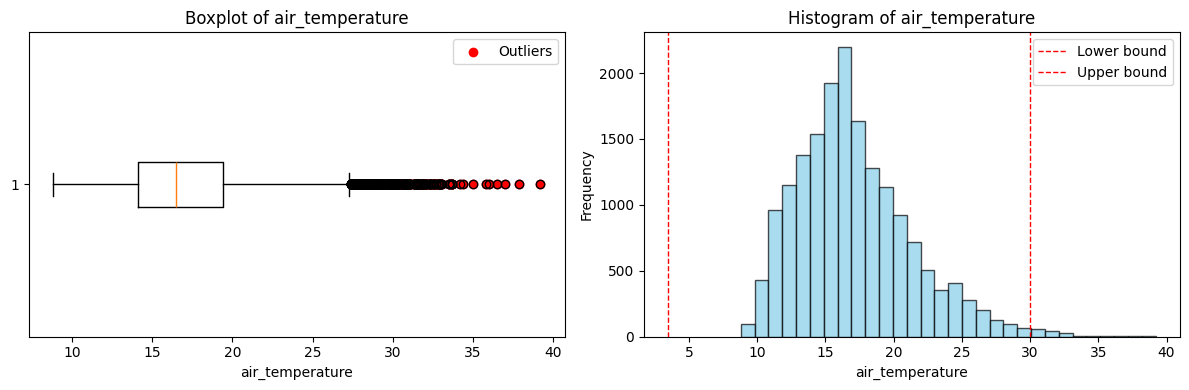

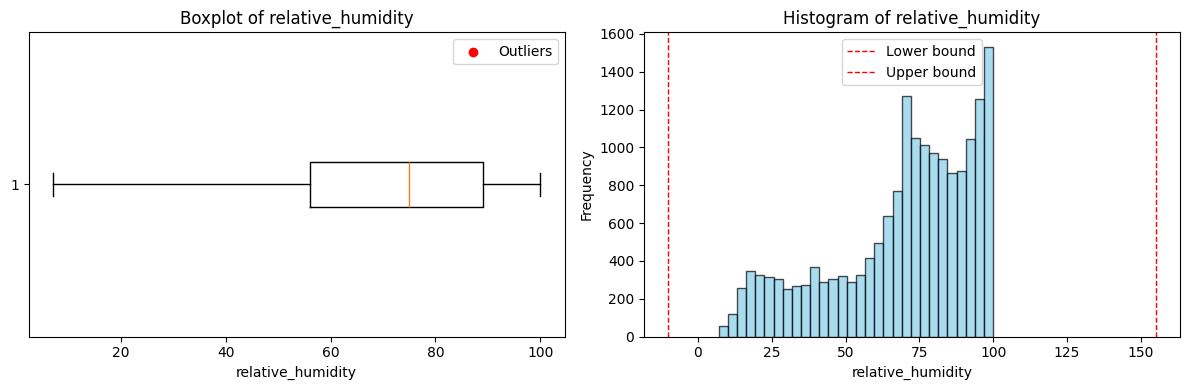

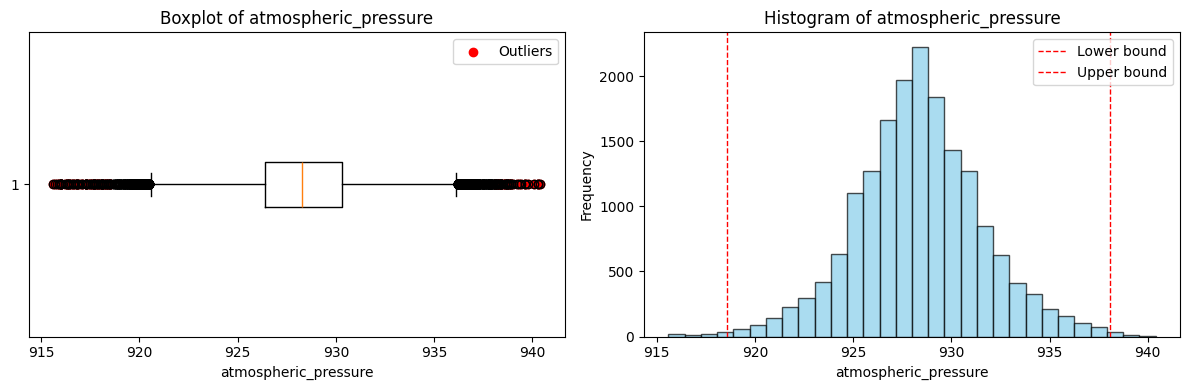

  air_temperature outlier row indices: [Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-07-12 10:00:00+0000', tz='UTC'), Timestamp('2023-07-12 11:00:00+0000', tz='UTC'), Timestamp('2023-07-12 12:00:00+0000', tz='UTC'), Timestamp('2023-07-12 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 10:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 17:00:00+0000', tz='UTC'), Timestamp('2023-07-14 13:00:00+0000', tz='UTC'), Timestamp('2023-08-10 11:00:00+0000', tz='UTC'), Timestamp('2023-08-10 12:00:00+0000', tz='UTC'), Timestamp('2023-08-10 13:00:0

In [66]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_la_orotava for KNN outlier detection...
air_temperature


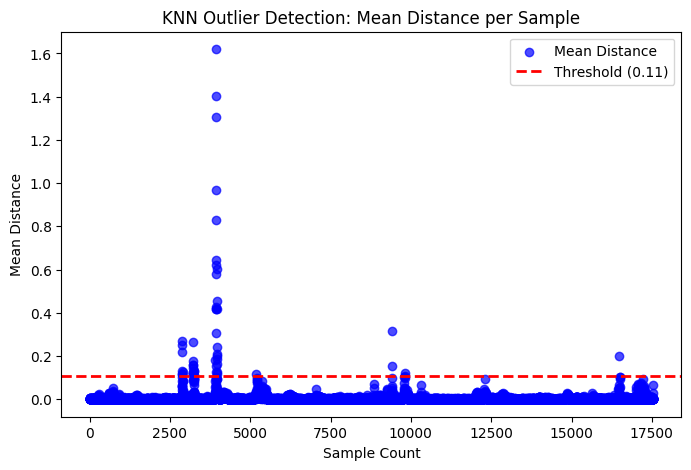

Detected 49 outliers at indices: [ 2866  2867  2868  2869  2873  2874  2892  3225  3226  3227  3228  3229
  3230  3231  3232  3233  3250  3252  3253  3919  3920  3921  3922  3923
  3924  3925  3926  3927  3928  3943  3944  3945  3946  3947  3951  3952
  3953  3954  3955  3956  3968  3969  3970  3971  5195  9414  9415  9807
 16472]
atmospheric_pressure


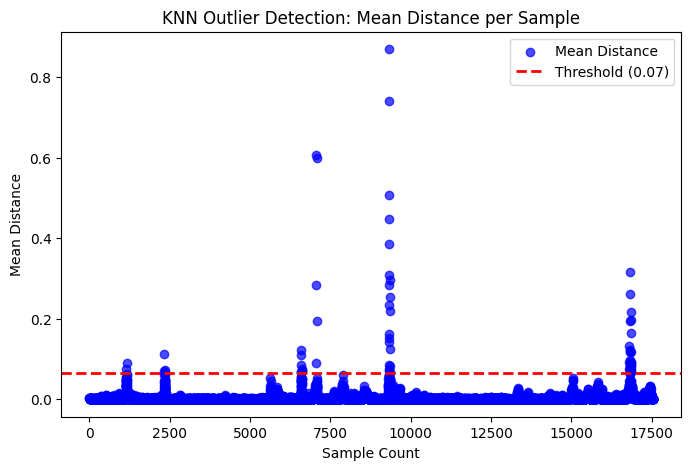

Detected 66 outliers at indices: [ 1146  1157  2331  2335  2347  6580  6582  6590  6593  6595  6600  6601
  6604  7064  7065  7066  7067  7068  9315  9319  9320  9322  9324  9325
  9326  9327  9328  9329  9330  9331  9333  9336  9339  9340  9341  9342
  9343  9345 16786 16787 16788 16811 16812 16821 16822 16823 16824 16825
 16827 16832 16833 16834 16835 16836 16837 16843 16844 16845 16846 16847
 16848 16849 16850 16857 16858 16859]
relative_humidity


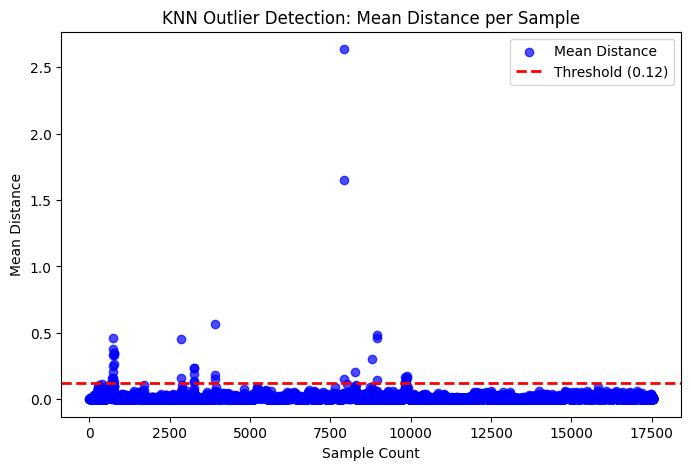

Detected 36 outliers at indices: [ 705  722  723  724  725  726  730  731  767  768  769  770  773 2837
 2838 3239 3240 3241 3244 3248 3920 3921 3922 7915 7916 7917 8271 8789
 8947 8952 8953 9832 9834 9840 9873 9874]
Processing openmeteo_la_orotava for KNN outlier detection...
air_temperature


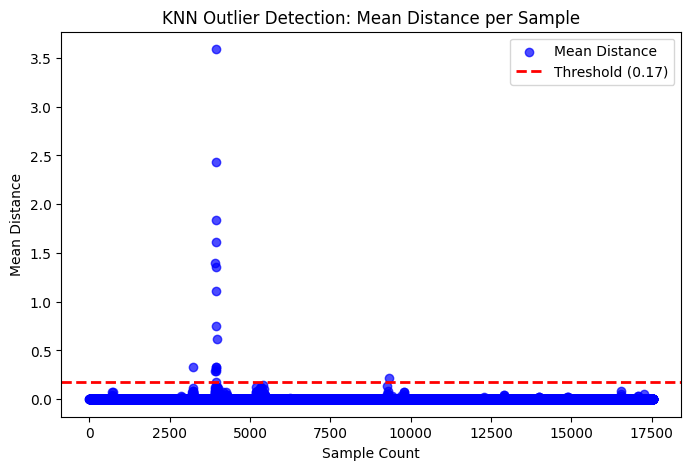

Detected 17 outliers at indices: [3228 3921 3922 3923 3924 3925 3926 3927 3946 3947 3948 3949 3950 3951
 3952 3972 9311]
atmospheric_pressure


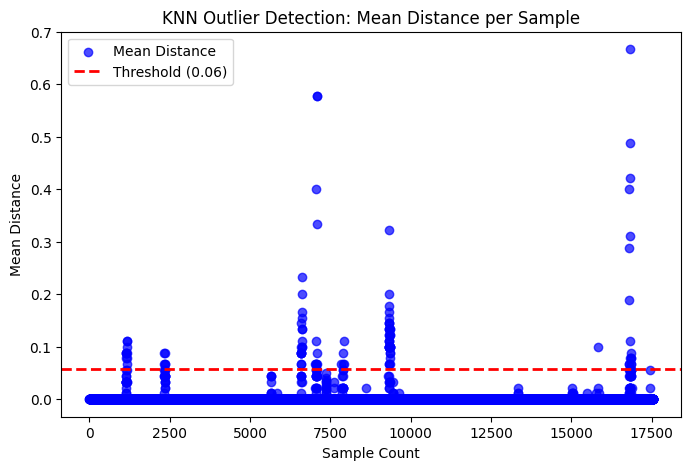

Detected 103 outliers at indices: [ 1133  1146  1147  1148  1154  1155  1156  1157  1158  1159  2333  2335
  2337  2345  2347  6582  6583  6591  6592  6593  6594  6595  6596  6599
  6600  6601  6602  6603  6604  6605  6606  6607  6608  7019  7052  7058
  7059  7065  7066  7067  7068  7069  7070  7077  7835  7883  7906  7907
  7908  9315  9316  9317  9318  9319  9320  9321  9322  9323  9324  9325
  9326  9327  9328  9329  9330  9331  9332  9333  9334  9335  9336  9337
  9338  9339  9340  9341  9342  9343  9344  9345  9346  9347  9349  9351
  9352  9353 15828 16786 16787 16788 16789 16791 16811 16834 16835 16836
 16837 16838 16845 16846 16850 16859 16860]
relative_humidity


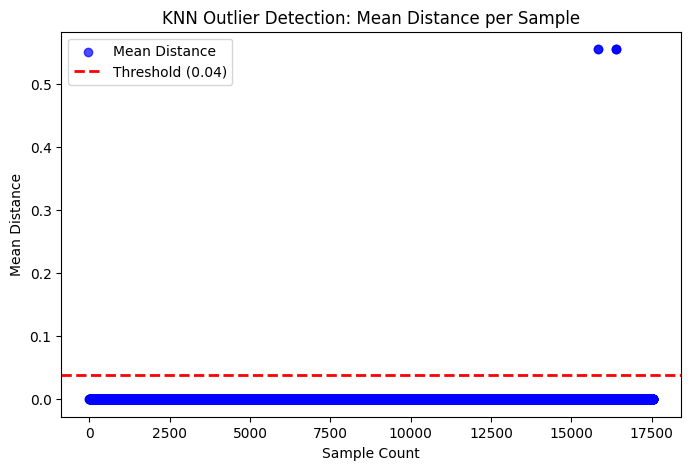

Detected 5 outliers at indices: [15820 15824 16391 16392 16393]


In [67]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_la_orotava...


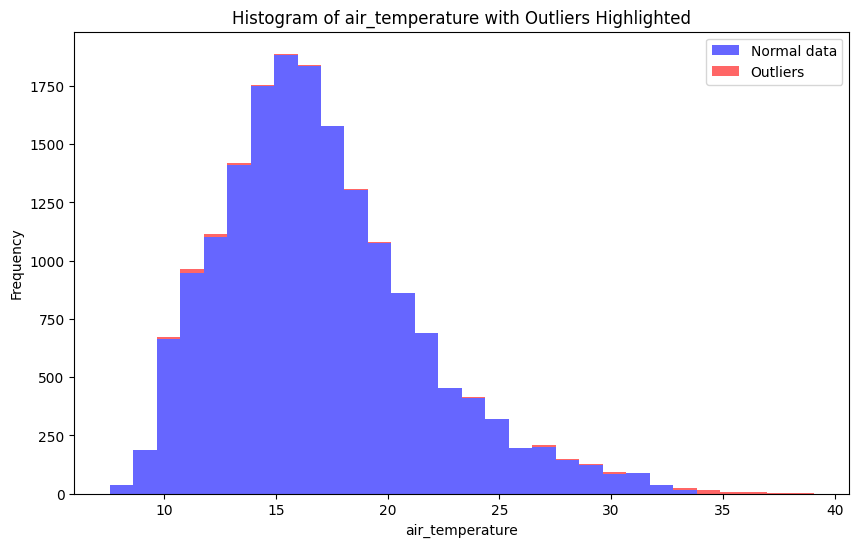

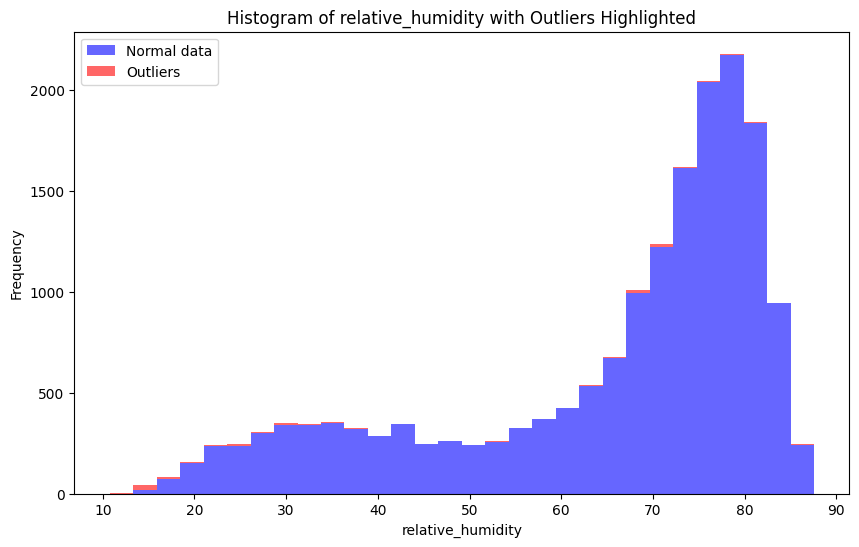

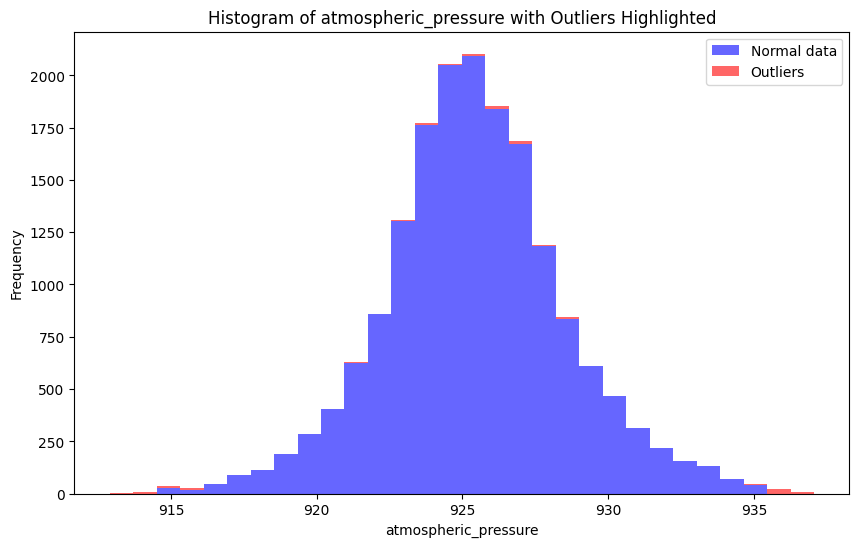

Plotting histogram for openmeteo_la_orotava...


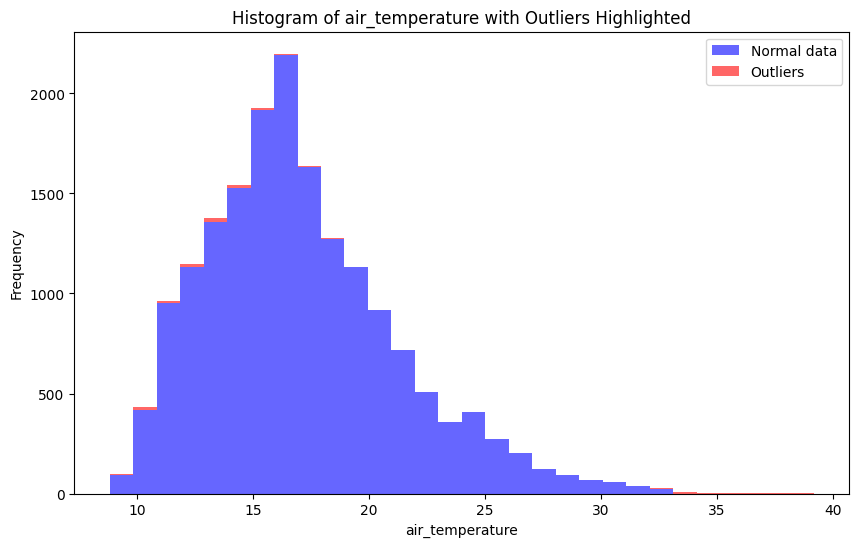

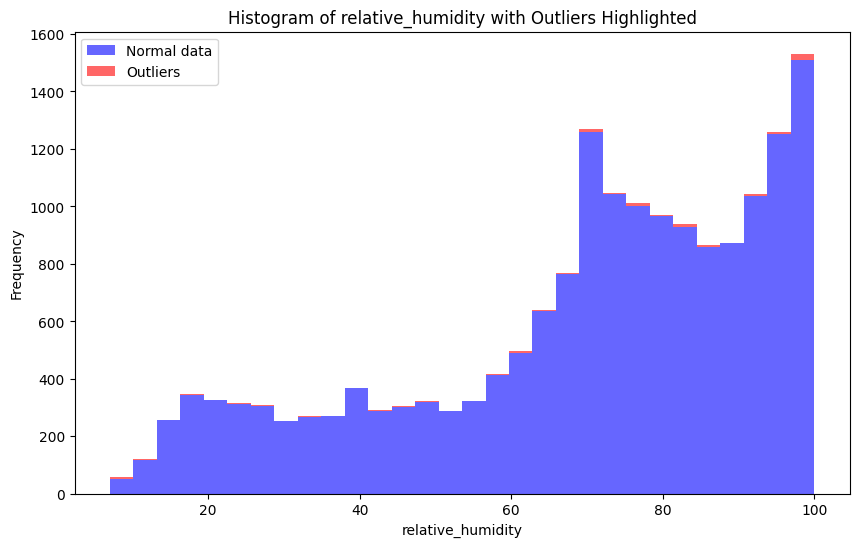

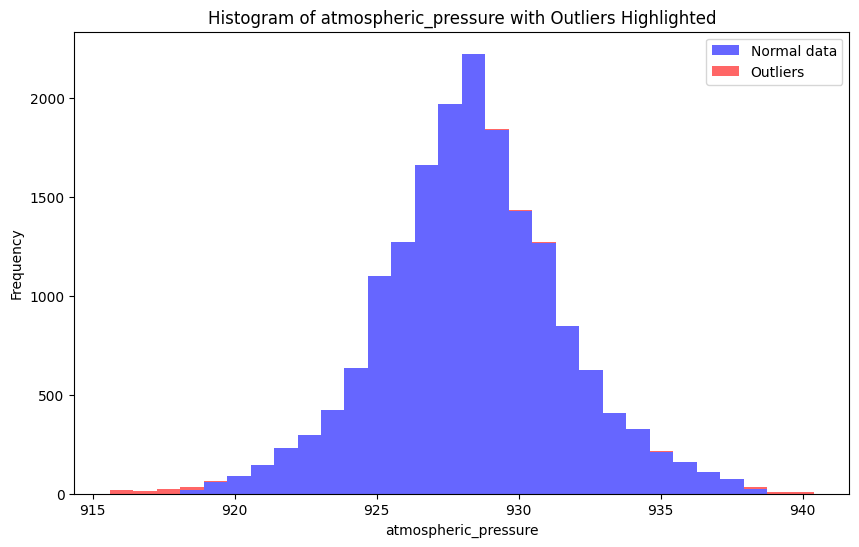

In [68]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [69]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_la_orotava...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000028 Hz, Period: 974.67 hours, Magnitude: 8818.0774
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 9048.6145
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 9381.9846
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 19957.7504
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 25900.3821


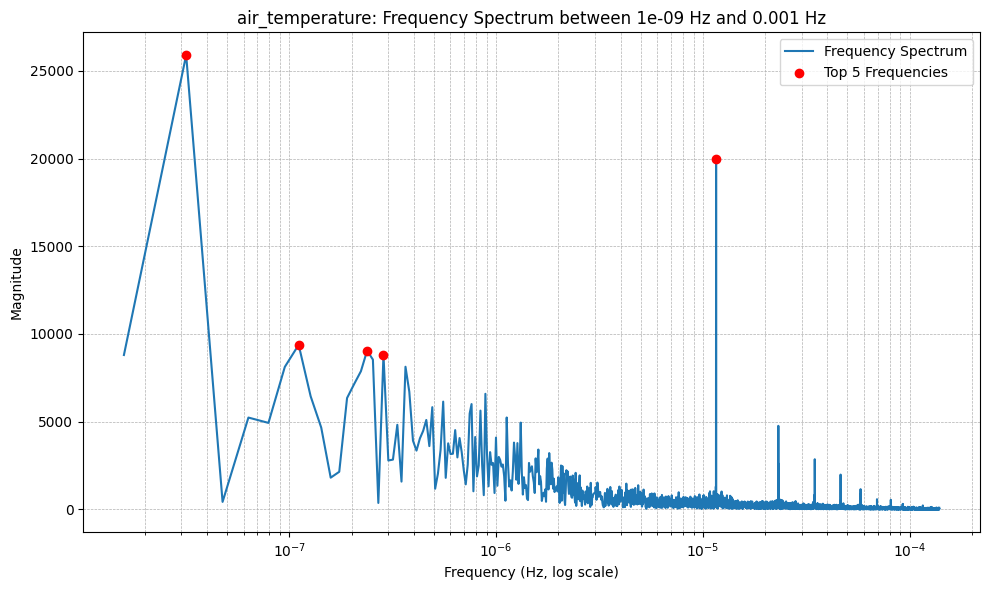

Top 5 frequencies with highest magnitude:
Frequency: 0.00000025 Hz, Period: 1096.50 hours, Magnitude: 34630.3157
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 36112.1310
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 38610.0611
Frequency: 0.00000028 Hz, Period: 974.67 hours, Magnitude: 42020.3388
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 57282.2077


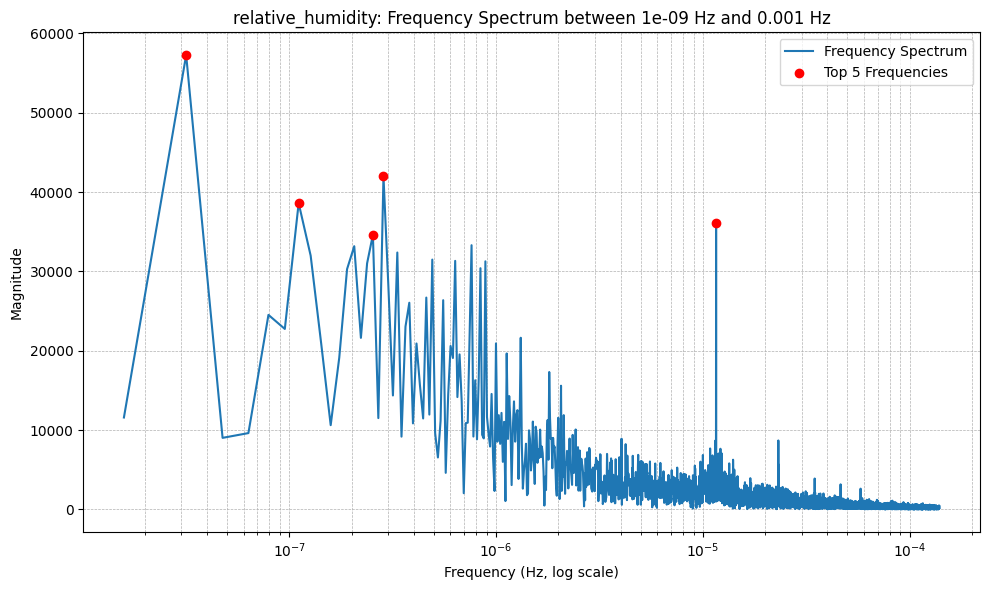

Top 5 frequencies with highest magnitude:
Frequency: 0.00000030 Hz, Period: 923.37 hours, Magnitude: 6442.2926
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 6778.8135
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 7580.4261
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 10540.3151
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 12284.5251


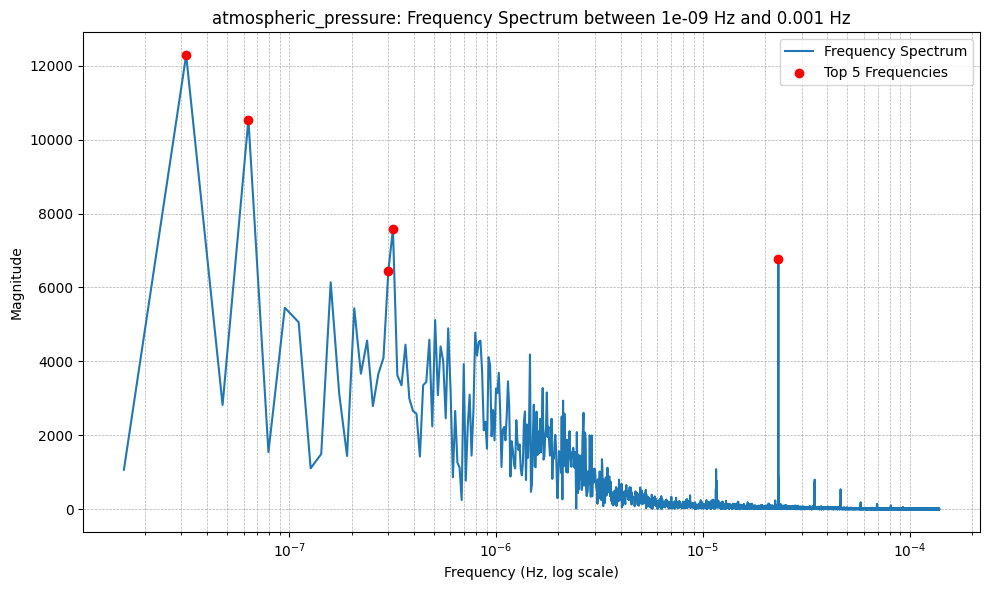

Plotting frequencies for openmeteo_la_orotava...
Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 8545.0015
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 9099.0071
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 9124.7405
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 20226.4959
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24543.5443


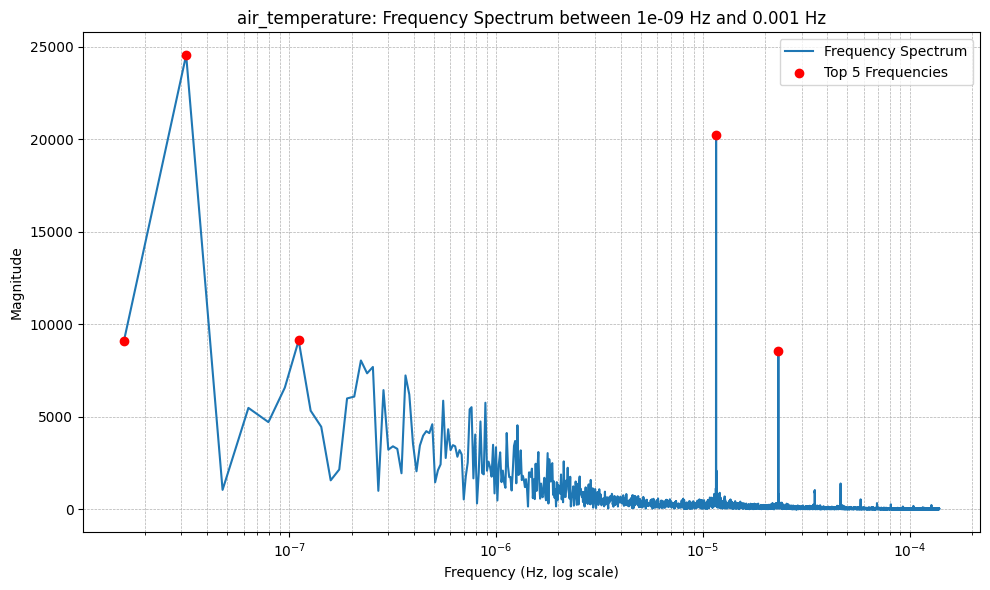

Top 5 frequencies with highest magnitude:
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 45152.6601
Frequency: 0.00000025 Hz, Period: 1096.50 hours, Magnitude: 46693.4096
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 57492.0802
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 63795.1521
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 64294.6823


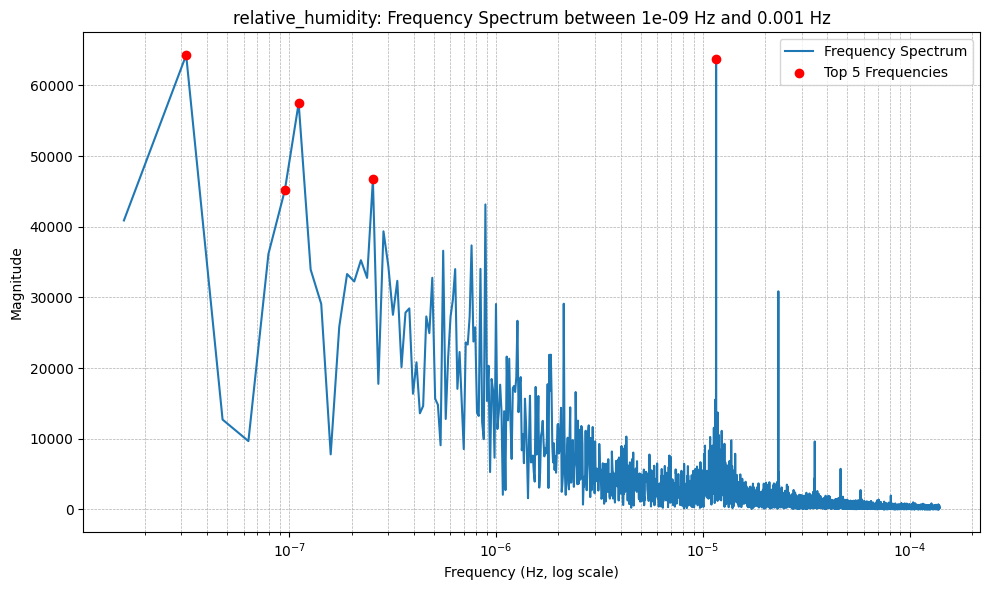

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7351.0995
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 7845.5785
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 8406.9258
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 9608.4474
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 11582.2792


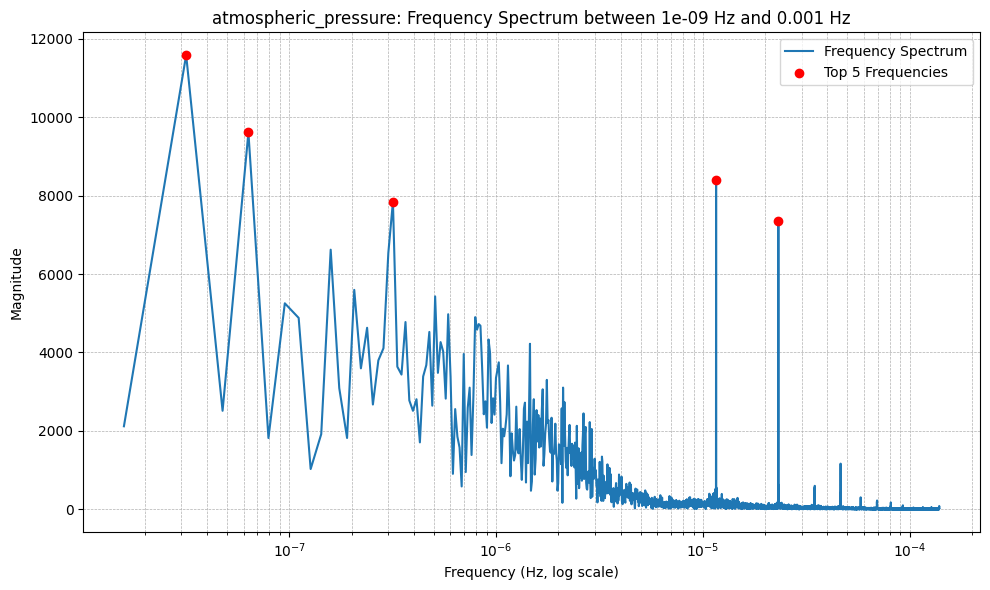

In [70]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [71]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_la_orotava...


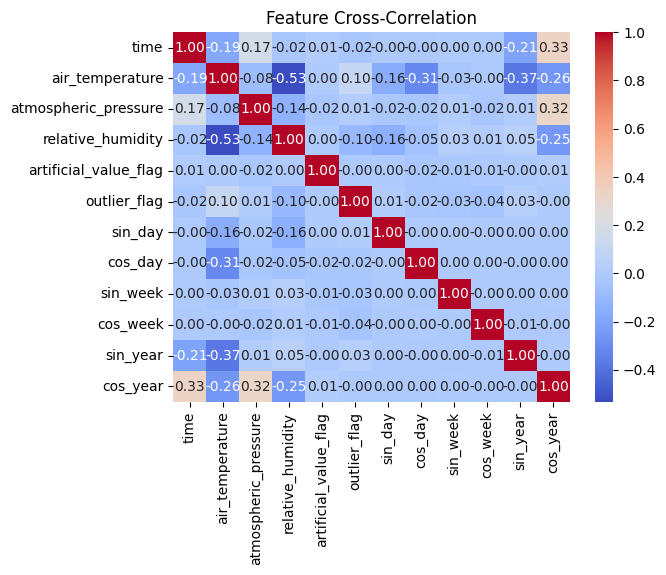

Plotting correlations for openmeteo_la_orotava...


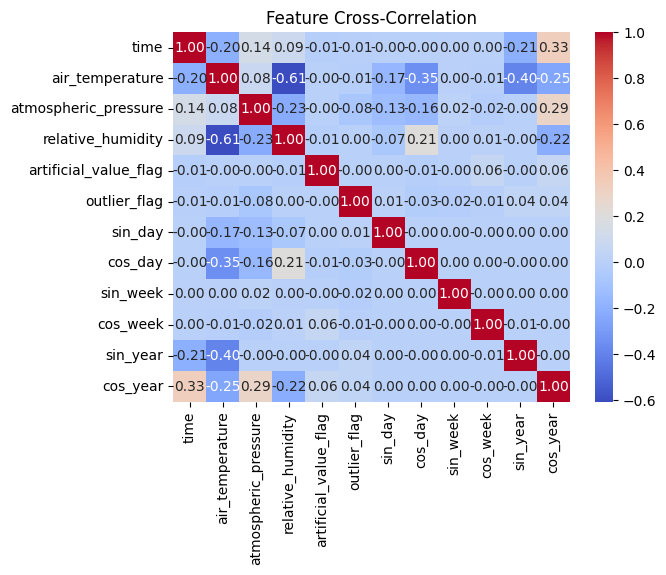

In [72]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [73]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [74]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)